# Self Organizing Map

## Importing the libraries

In [1]:
!pip install MiniSom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


## Importing the dataset

In [2]:
dataset = pd.read_csv('Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values

## Feature Scaling

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

## Training the SOM

In [4]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)

## Visualizing the results

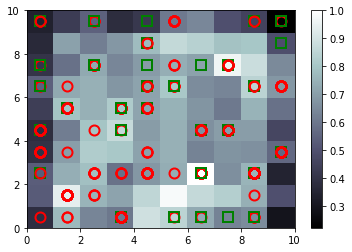

In [5]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

## Finding the frauds


In [6]:
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(6,2)], mappings[(7,7)]), axis = 0)
frauds = sc.inverse_transform(frauds)

## Printing the Fraud Clients

In [7]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
  print(int(i))

Fraud Customer IDs
15767264
15704581
15761854
15725776
15815040
15697460
15788442
15737998
15586183
15718921
15633944
15607988
15801072
15683993
15797767
15744044
15632010
15804235
15627365
15573798
15647295
15791944
15576680
15620570
15592412
15686461
15680643
15692137
15668830
15796569
15805212
15712877
15740458
15807546
15796111
15809800
15676909
15647898
15679801
15781975
15770255
15705506
15812470
15788215
15722535


## Going from Unsupervised to Supervised Deep Learning

In [8]:
# Create Matrix of Features
customers = dataset.iloc[:, 1:].values

In [9]:
# Create Dependent Variable
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

In [10]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

## Building the ANN

In [11]:
# Initializing the ANN
ann = Sequential()

In [12]:
# Adding the input layer and the first hidden layer
ann.add(Dense(units=2, kernel_initializer = 'uniform', activation='relu'))

# Adding the output layer
ann.add(Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid'))

# Compiling
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
# Training the ANN on the Training set
ann.fit(customers, is_fraud, batch_size = 1, epochs = 10)

Epoch 1/10
690/690 [==============================] - 2s 2ms/step - loss: 0.5200 - accuracy: 0.9319
Epoch 2/10
690/690 [==============================] - 1s 1ms/step - loss: 0.3120 - accuracy: 0.9348
Epoch 3/10
690/690 [==============================] - 1s 1ms/step - loss: 0.2404 - accuracy: 0.9348
Epoch 4/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1969 - accuracy: 0.9348
Epoch 5/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1762 - accuracy: 0.9348
Epoch 6/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1634 - accuracy: 0.9348
Epoch 7/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1541 - accuracy: 0.9348
Epoch 8/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1455 - accuracy: 0.9348
Epoch 9/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1381 - accuracy: 0.9348
Epoch 10/10
690/690 [==============================] - 1s 2ms/step - loss: 0.1313 - accuracy: 0.9348

## Predicting test set results

In [14]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['user_id', 'Probability_of_fraud']
y_pred

,user_id,Probability_of_fraud
0,15776156.0,0.085174
1,15739548.0,0.001236
2,15662854.0,0.001000
3,15687688.0,0.002849
4,15715750.0,0.013031
...,...,...
685,15808223.0,0.043984
686,15769980.0,0.023150
687,15675450.0,0.002687
688,15776494.0,0.001075
